In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import numpy.ma as ma
import cartopy.crs as ccrs
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 
import sys

In [17]:
import plot_bathymetryGradients as pbgrad
importlib.reload(pbgrad)

<module 'plot_bathymetryGradients' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_bathymetryGradients.py'>

<IPython.core.display.Javascript object>


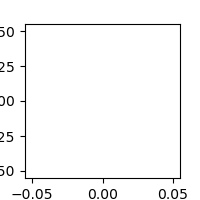

In [92]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
bathy_gradient = pbgrad.compute_bathymetryGradients(lonstep=5, latstep=1)
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')
lonlen = len(bathy.lon)
lonindices = np.arange(0, lonlen+1, 5) # lonstep=5, every 5th longitude
lonindices[-1] = lonindices[-1] - 1
bathyS = bathy.isel(lon=lonindices, lat=np.arange(0, 3600, 1))
bathy_gradient = ma.masked_array(np.array(bathy_gradient))
bathy_gradient.mask = (bathy_gradient < 0.002) | (bathyS.elevation < -3500) | (bathyS.elevation > -800)
bathyS['bathy_gradient'] = (['lat', 'lon'], bathy_gradient)
bathyS['bathy_gradient_mask'] = (['lat', 'lon'], bathy_gradient.mask)

In [138]:
slopeLonLims = np.array([ [-40.,-25.] ,  [-5, 0], [0,8], 
                  [70, 88], [126,134], [148, 155],
                 [155, 170], [170, 180], [-120, -100],
                 [-90, -80], [-80, -75], [-75, -70]] + 
                        [[-25, -5], [8, 70], [88, 126], [134, 148], [-180, -120], [-100, -90], [-70, -40]])

slopeLatLims = [ [-75, -71], [-85, -67.6], [-85, -67.6],
                   [-67.5, -63.8], [-65, -60], [-66.7, -64.5],
                 [-73, -67], [-73, -70], [-73, -70],
                 [-70, -60], [-69, -60], [-68, -60] ] + [[-80, -60]]*4 + [[-80, -69]] + [[-80,-60]]*2

#slopeLonLims[slopeLonLims < 0] = slopeLonLims[slopeLonLims < 0] + 360
#slopeLonLims[1][1] = 360

In [3]:
dfmg = pd.read_csv("/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/dfmg_corrected_DIST_GLINE.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg['JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [4]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [141]:
#dfmg['SHELF_BREAK_PROFILE'] = np.zeros(len(dfmg), dtype=bool)

In [142]:
def find_shelf_break_profiles(gdf):
    lat, lon = gdf.LATITUDE.values[0], gdf.LONGITUDE.values[0]
    sel_bool = ~bathyS.sel(lat=lat, lon=lon, method="nearest").bathy_gradient_mask.values
    
    lonlatlim_bool = True
    for i in range(len(slopeLonLims)):
        if((lon >= slopeLonLims[i][0]) & (lon <= slopeLonLims[i][1])):
            if((lat < slopeLatLims[i][0]) | (lat > slopeLatLims[i][1])):
                lonlatlim_bool = False
    
    gdf['SHELF_BREAK_PROFILE'] = [sel_bool & lonlatlim_bool] * len(gdf)
    
    return gdf

In [143]:
#dfmg = dfmg.groupby(["LATITUDE", "LONGITUDE"]).apply(find_shelf_break_profiles)

In [18]:
nonull = ~dfmg.gamman.isnull()

In [ ]:
plt.hist(dfmg.loc[nonull, 'gamman'].values, np.arange(27,29,0.01))

plt.show()

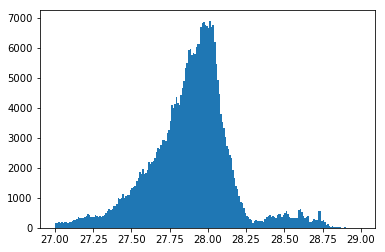

In [20]:
plt.hist(dfmg.loc[dfmg.SHELF_BREAK_PROFILE & nonull, 'gamman'].values, np.arange(27,29,0.01))

plt.show()

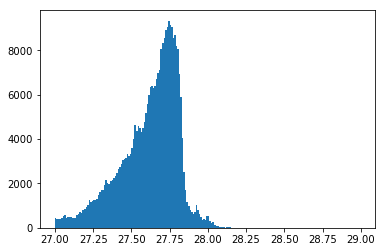

In [21]:
plt.hist(dfmg.loc[dfmg.SHELF_BREAK_PROFILE & nonull, 'POT_DENSITY'].values, np.arange(27,29,0.01))

plt.show()

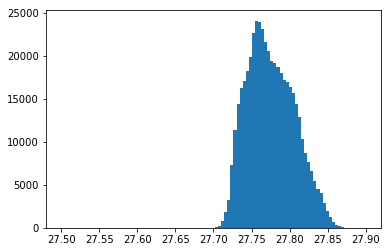

In [29]:
dfsel = (dfmg.gamman > 28) & (dfmg.gamman < 28.27)
plt.hist(dfmg.loc[dfsel, 'POT_DENSITY'].values, np.linspace(27.5, 27.9, 100))
plt.show()

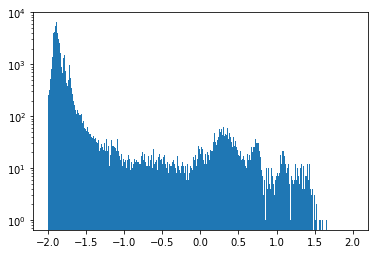

In [48]:
dfsel = dfmg.POT_DENSITY >= 27.846
plt.hist(dfmg.loc[dfsel, "CTEMP"].values, np.linspace(-2, 2, 1000))
plt.yscale("log")
plt.show()

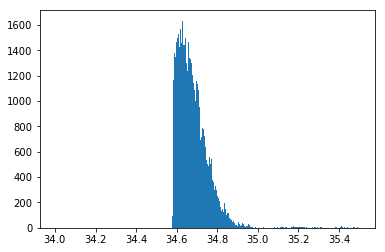

In [33]:
dfsel = dfmg.POT_DENSITY > 27.85
plt.hist(dfmg.loc[dfsel, "PSAL_ADJUSTED"].values, np.linspace(34, 35.5, 1000))
plt.show()

In [109]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman', 'SHELF_BREAK_PROFILE'],
      dtype='object')

In [110]:
dfmg.to_csv("./dfmg_corrected_DIST_GLINE.csv")

In [25]:
len(dfmg.loc[dfmg.SHELF_BREAK_PROFILE & (dfmg.gamman > 27.95) & (dfmg.gamman < 28.05)])

90910

In [38]:
def plot_slope_gamman_surfaces(gn1 = 28, gn2 = 28.27, save=False, savename="untitled.png"):
    plt.close(1)
    plt.figure(1, figsize=(7.48, 7))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,0.1, 0.1], wspace=0)
    
    dfsel_slope = dfmg.SHELF_BREAK_PROFILE
    dfsel_gn1 = (dfmg.gamman > gn1-0.05) & (dfmg.gamman < gn1+0.05)
    depth_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].DEPTH
    months_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].JULD.dt.month
    CTEMP_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].CTEMP
    
    dfsel_gn2 = (dfmg.gamman > gn2)
    depth_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].DEPTH
    months_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].JULD.dt.month
    CTEMP_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].CTEMP
    
    month_ax = np.linspace(1,12, 100)
    lon_ax = np.linspace(-180, 180, 1280)
    lon_grid, month_grid = np.meshgrid(lon_ax, month_ax)
    
    items = [depth_gn1, depth_gn2, CTEMP_gn1, CTEMP_gn2]
    indices = [dfsel_gn1 & dfsel_slope, dfsel_gn2 & dfsel_slope, dfsel_gn1 & dfsel_slope, dfsel_gn2 & dfsel_slope]
    
    vmin=[-1200, -1.5]
    vmax = [0.1, 1.5]
    extend = ['min', 'both']
    levs = [np.arange(-1200, 0.1, 10), np.linspace(vmin[1], vmax[1], 100)]
    cmap = ['viridis', 'bwr']
    CF = []
    ax = []
    for i in range(len(items)):
        element = items[i]
        ind = indices[i]
        gridded_data = griddata(np.array([dfmg.loc[ind].LONGITUDE, dfmg.loc[ind].JULD.dt.month]).T, 
                           element, (lon_grid, month_grid))
        ax.append(plt.subplot(gs[i//2, i%2]))
        CF.append(ax[-1].contourf(lon_grid, month_grid, gridded_data, vmin=vmin[i//2], vmax=[i//2], 
                                 extend=extend[i//2], levels=levs[i//2], cmap=cmap[i//2]))
        
    subplot_titles = ["$\gamma^n=28$", "$\gamma^n>28.27$", "$\gamma^n=28$", "$\gamma^n>28.27$"]
    ax_colorbar1 = plt.subplot(gs[0, 3])
    cbr = Colorbar(ax = ax_colorbar1, mappable = CF[0], orientation = 'vertical')
    cbr.ax.set_ylabel("Depth (m)")
    
    ax_colorbar2 = plt.subplot(gs[1, 3])
    cbr = Colorbar(ax = ax_colorbar2, mappable = CF[2], orientation = 'vertical')
    cbr.ax.set_ylabel("CT $^O$C")

    for i in range(4):
        ax[i].set_xlim(-190, 190)
        ax[i].set_title(subplot_titles[i])
        ax[i].set_xticks(np.arange(-180, 181, 60))
    for i in range(1,4,2):
        ax[i].set_yticklabels("")
        ax[i].set_yticks([])
        ax[i-1].set_ylabel("Months")
    for i in range(2):
        #ax[i].set_xticklabels("")
        #ax[i].set_xticks([])
        pass
    if save:    
        plt.savefig(savename, dpi=300, bbox_inches="tight")
    plt.show()


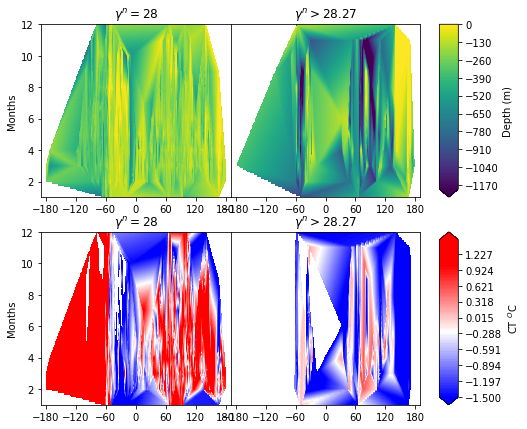

In [39]:
plot_slope_gamman_surfaces(save=True, savename="./Images/slopeFront/gamman_CT_Depth_Hovmoller.png")

In [98]:
def find_topOfSigmaSurfaceDepth(gdf):
    return gdf.DEPTH.max()
def find_topOfSigmaSurfaceDepth_corr_lon(gdf):
    return gdf.LONGITUDE.values[0]
def find_topOfSigmaSurfaceDepth_corr_months(gdf):
    return gdf.JULD.dt.month.values[0]
def find_topOfSigmaSurfaceDepth_corr_CTEMP(gdf):
    return gdf.CTEMP.values[0]


    
dfsel = dfmg.SHELF_BREAK_PROFILE & (dfmg.POT_DENSITY > 27.86)
topOfSigmaSurface_2786 = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth)
topOfSigmaSurface_2786_corr_lon = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_lon)
topOfSigmaSurface_2786_corr_months = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_months)
topOfSigmaSurface_2786_corr_CTEMP = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_CTEMP)


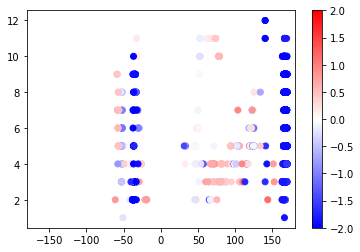

In [106]:
SCR = plt.scatter(topOfSigmaSurface_2786_corr_lon, topOfSigmaSurface_2786_corr_months, 
                  c= topOfSigmaSurface_2786_corr_CTEMP, cmap='bwr', vmin=-2, vmax=2)
plt.xlim(-180, 180)
plt.colorbar(SCR)
plt.show()

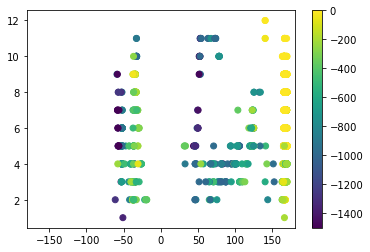

In [107]:
SCR = plt.scatter(topOfSigmaSurface_2786_corr_lon, topOfSigmaSurface_2786_corr_months, 
                  c= topOfSigmaSurface_2786,  vmin=-1500, vmax=0)
plt.xlim(-180, 180)
plt.colorbar(SCR)
plt.show()

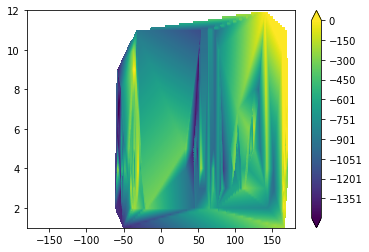

In [97]:
month_ax = np.linspace(1,12, 100)
lon_ax = np.linspace(-180, 180, 1280)
lon_grid, month_grid = np.meshgrid(lon_ax, month_ax)
gridded_data = griddata(np.array([topOfSigmaSurface_2786_corr_lon, topOfSigmaSurface_2786_corr_months]).T, 
                           topOfSigmaSurface_2786, (lon_grid, month_grid), method='linear')
#ax.append(plt.subplot(gs[i//2, i%2]))
CF = plt.contourf(lon_grid, month_grid, gridded_data, cmap='viridis', vmin=-1500, vmax=0, 
                                 extend='both', levels=np.linspace(-1500, 0, 1000) )
plt.colorbar()
plt.show()

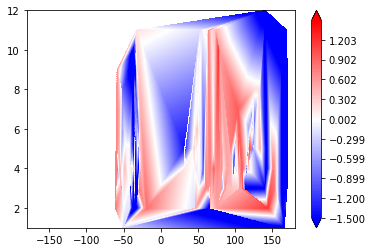

In [100]:
month_ax = np.linspace(1,12, 1000)
lon_ax = np.linspace(-180, 180, 1280)
lon_grid, month_grid = np.meshgrid(lon_ax, month_ax)
gridded_data = griddata(np.array([topOfSigmaSurface_2786_corr_lon, topOfSigmaSurface_2786_corr_months]).T, 
                           topOfSigmaSurface_2786_corr_CTEMP, (lon_grid, month_grid), method='linear')
#ax.append(plt.subplot(gs[i//2, i%2]))
CF = plt.contourf(lon_grid, month_grid, gridded_data, cmap='bwr', vmin=-1.5, vmax=1.5, 
                                 extend='both', levels=np.linspace(-1.5, 1.5, 1000) )
plt.colorbar()
plt.show()

In [12]:
def find_topOfSigmaSurfaceDepth(gdf):
    return gdf.DEPTH.max()
def find_topOfSigmaSurfaceDepth_corr_lon(gdf):
    return gdf.LONGITUDE.values[0]
def find_topOfSigmaSurfaceDepth_corr_months(gdf):
    return gdf.JULD.dt.month.values[0]
def find_topOfSigmaSurfaceDepth_corr_CTEMP(gdf):
    return gdf.CTEMP.values[0]


    
dfsel = dfmg.SHELF_BREAK_PROFILE & (dfmg.POT_DENSITY > 27.86)
topOfSigmaSurface_2786 = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth)
topOfSigmaSurface_2786_corr_lon = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_lon)
topOfSigmaSurface_2786_corr_months = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_months)
topOfSigmaSurface_2786_corr_CTEMP = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").\
                                                    apply(find_topOfSigmaSurfaceDepth_corr_CTEMP)

def plot_slope_sigma0_surfaces(gn1 = 27.67, gn2 = 27.86, save=False, savename="Untitled.png", tol=0.01):
    plt.close(1)
    plt.figure(1, figsize=(7.48, 7))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,0.1, 0.1], wspace=0.05)
    
    dfsel_slope = dfmg.SHELF_BREAK_PROFILE
    dfsel_gn1 = (dfmg.POT_DENSITY > gn1-tol) & (dfmg.POT_DENSITY < gn1+tol)
    depth_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].DEPTH
    months_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].JULD.dt.month
    CTEMP_gn1 = dfmg.loc[dfsel_gn1 & dfsel_slope].CTEMP
    
    dfsel_gn2 = (dfmg.POT_DENSITY > gn2)
    depth_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].DEPTH
    months_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].JULD.dt.month
    CTEMP_gn2 = dfmg.loc[dfsel_gn2 & dfsel_slope].CTEMP
    
    month_ax = np.linspace(1,12, 100)
    lon_ax = np.linspace(-180, 180, 1280)
    lon_grid, month_grid = np.meshgrid(lon_ax, month_ax)
    
    items = [depth_gn1, depth_gn2, CTEMP_gn1, CTEMP_gn2]
    indices = [dfsel_gn1 & dfsel_slope, dfsel_gn2 & dfsel_slope, dfsel_gn1 & dfsel_slope, dfsel_gn2 & dfsel_slope]
    
    vmin=[-1200, -1.5]
    vmax = [0.1, 1.5]
    extend = ['min', 'both']
    levs = [np.arange(-1200, 0.1, 10), np.linspace(vmin[1], vmax[1], 100)]
    cmap = ['viridis', 'bwr']
    CF = []
    ax = []
    for i in range(len(items)):
        element = items[i]
        ind = indices[i]
        gridded_data = griddata(np.array([dfmg.loc[ind].LONGITUDE, dfmg.loc[ind].JULD.dt.month]).T, 
                           element, (lon_grid, month_grid), method='linear')
        ax.append(plt.subplot(gs[i//2, i%2]))
        CF.append(ax[-1].contourf(lon_grid, month_grid, gridded_data, cmap=cmap[i//2], vmin=vmin[i//2], vmax=[i//2], 
                                 extend=extend[i//2], levels=levs[i//2]))
        
    subplot_titles = ["$\sigma_O=$"+str(gn1), "$\sigma_0>$"+str(gn2), "$\sigma_O=$"+str(gn1), "$\sigma_0>$"+str(gn2)]
    ax_colorbar1 = plt.subplot(gs[0, 3])
    cbr = Colorbar(ax = ax_colorbar1, mappable = CF[0], orientation = 'vertical')
    cbr.ax.set_ylabel("Depth (m)")
    
    ax_colorbar2 = plt.subplot(gs[1, 3])
    cbr = Colorbar(ax = ax_colorbar2, mappable = CF[2], orientation = 'vertical')
    cbr.ax.set_ylabel("CT $^O$C")
    
    xticklabels = [list(np.arange(-180, 181, 60)), ['']+list(np.arange(-120, 181, 60))]
    for i in range(4):
        ax[i].set_xlim(-190, 190)
        ax[i].set_title(subplot_titles[i])
        ax[i].set_xticks(np.arange(-180, 181, 60))
        ax[i].set_xticklabels(xticklabels[i%2])
    for i in range(1,4,2):
        ax[i].set_yticklabels("")
        ax[i].set_yticks([])
        ax[i-1].set_ylabel("Months")
    for i in range(2):
        #ax[i].set_xticklabels("")
        #ax[i].set_xticks([])
        pass
    
    if save:
        plt.savefig(savename, dpi=300, bbox_inches="tight")
    plt.show()


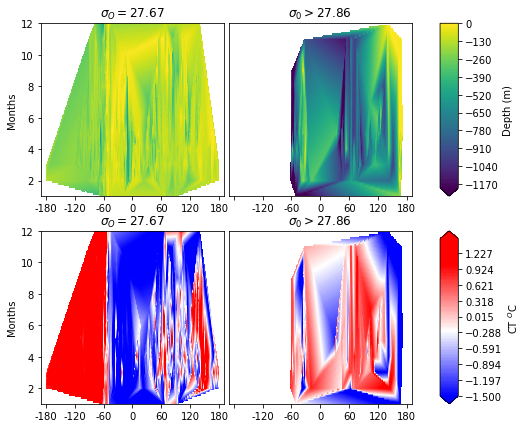

In [13]:
plot_slope_sigma0_surfaces(save=True, savename="./Images/slopeFront/sigma0_CT_Depth_Hovmoller.png")

In [37]:
def find_topOfSigmaSurfaceDepth(gdf):
    return gdf.DEPTH.max()
def find_topOfSigmaSurfaceDepth_corr_lon(gdf):
    return gdf.LONGITUDE.values[0]
def find_topOfSigmaSurfaceDepth_corr_months(gdf):
    return gdf.JULD.dt.month.values[0]
def find_topOfSigmaSurfaceDepth_corr_CTEMP(gdf):
    return gdf.CTEMP.values[0]
def find_topOfSigmaSurfaceDepth_corr_sal(gdf):
    return gdf.PSAL_ADJUSTED.values[0]


def plot_slope_sigma0_surfaces_CF(sigma_surfaces=[27.67, 27.74, 27.86], surface_type=["equal_to", "equal_to", 
                                        "greater_than"], save=False, savename="Untitled.png", tol=0.01, 
                              wd=190/25.4, ht=230/25.4):
    plt.close(1)
    plt.figure(1, figsize=(wd, ht))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1,1,1,0.01, 0.1], wspace=0.01, hspace=0.01)
    
    vmin=[-1200, -1.5, 34.4]
    vmax = [0.1, 1.5, 34.8]
    extend = ['min', 'both']
    levs = [np.linspace(vmin[0], vmax[0], 1000), np.linspace(vmin[1], vmax[1], 99), np.linspace(vmin[2], vmax[2], 100)]
    cmap = ['viridis', 'bwr', 'viridis']
    CF = []
    ax = []
    lon_grid, month_grid = np.meshgrid(np.linspace(-180, 180, 2560), np.linspace(1, 12, 100))
    subplot_titles = ["$\sigma_O=$"+str(sigma_surfaces[0]), "$\sigma_0=$"+str(sigma_surfaces[1]), "$\sigma_O>$"+str(sigma_surfaces[2])]
    
    for i in range(len(sigma_surfaces)):
        if(surface_type[i] == "equal_to"):
            dfsel = (dfmg.POT_DENSITY > sigma_surfaces[i]-tol) &  (dfmg.POT_DENSITY < sigma_surfaces[i]+tol) & (dfmg.SHELF_BREAK_PROFILE)
        elif(surface_type[i] == "greater_than"):
            dfsel = (dfmg.POT_DENSITY > sigma_surfaces[i]) & (dfmg.SHELF_BREAK_PROFILE)
        else:
            raise Exception("surface_type can only be either equal_to or greater_than")

        topOfSigmaSurface = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth)
        topOfSigmaSurface_corr_lon = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth_corr_lon)
        topOfSigmaSurface_corr_months = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth_corr_months)
        topOfSigmaSurface_corr_CTEMP = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth_corr_CTEMP)
        topOfSigmaSurface_corr_sal = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth_corr_sal)        

        gridded_data = griddata(np.array([topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months]).T, topOfSigmaSurface, (lon_grid, month_grid), method='linear')
        ax.append(plt.subplot(gs[0, i]))
        CF.append(ax[-1].contourf(lon_grid, month_grid, gridded_data, cmap=cmap[0], vmin=vmin[0], vmax=vmax[0], extend='min', levels=levs[0]))
        ax[-1].set_xticklabels("")
        ax[-1].set_xticks([])
        ax[-1].set_title(subplot_titles[i])
        
        gridded_data = griddata(np.array([topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months]).T, topOfSigmaSurface_corr_CTEMP, (lon_grid, month_grid), method='linear')
        ax.append(plt.subplot(gs[1, i]))
        CF.append(ax[-1].contourf(lon_grid, month_grid, gridded_data, cmap=cmap[1], vmin=vmin[1], vmax=vmax[1], extend='both', levels=levs[1]))
        ax[-1].set_xticklabels("")
        ax[-1].set_xticks([])

        gridded_data = griddata(np.array([topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months]).T, topOfSigmaSurface_corr_sal, (lon_grid, month_grid), method='linear')
        ax.append(plt.subplot(gs[2, i]))
        CF.append(ax[-1].contourf(lon_grid, month_grid, gridded_data, cmap=cmap[2], vmin=vmin[2], vmax=vmax[2], extend='both', levels=levs[2]))

        if(i>0):
            for j in range(1,4,1):
                ax[-j].set_yticklabels("")
                ax[-j].set_yticks([])
                
        

    ax.append(plt.subplot(gs[0, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = CF[0], orientation = 'vertical')
    cbr.ax.set_ylabel("Depth (m)")
    
    ax.append(plt.subplot(gs[1, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = CF[1], orientation = 'vertical')
    cbr.ax.set_ylabel("CT $^O$C")

    ax.append(plt.subplot(gs[2, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = CF[2], orientation = 'vertical')
    cbr.ax.set_ylabel("Salinity (PSU)")
        
    if save:
        plt.savefig(savename, dpi=300, bbox_inches="tight")
    plt.show()


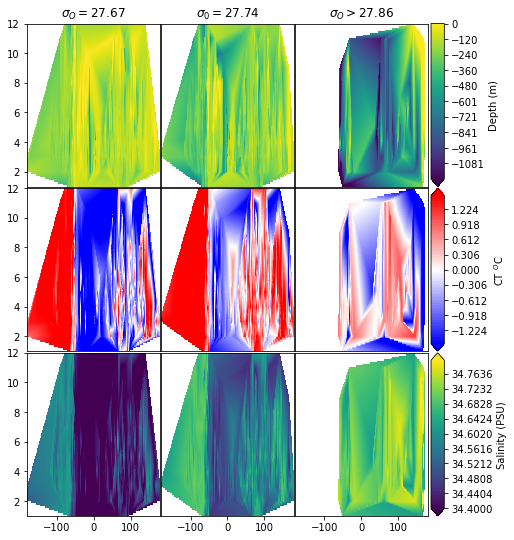

In [38]:
plot_slope_sigma0_surfaces_CF(save=True, savename="./Images/slopeFront/sigma_surfaces_hovmoller_CF.jpg")

In [35]:
def find_topOfSigmaSurfaceDepth(gdf):
    return gdf.DEPTH.max()
def find_topOfSigmaSurfaceDepth_corr_lon(gdf):
    return gdf.LONGITUDE.values[0]
def find_topOfSigmaSurfaceDepth_corr_months(gdf):
    return gdf.JULD.dt.month.values[0]
def find_topOfSigmaSurfaceDepth_corr_CTEMP(gdf):
    return gdf.CTEMP.values[0]
def find_topOfSigmaSurfaceDepth_corr_sal(gdf):
    return gdf.PSAL_ADJUSTED.values[0]


def plot_slope_sigma0_surfaces_SCR(sigma_surfaces=[27.67, 27.74, 27.86], surface_type=["equal_to", "equal_to", 
                                        "greater_than"], save=False, savename="Untitled.png", tol=0.01, 
                              wd=190/25.4, ht=230/25.4):
    plt.close(1)
    plt.figure(1, figsize=(wd, ht))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1,1,1,0.01, 0.1], wspace=0.01, hspace=0.01)
    
    vmin=[-1500, -1.5, 34.4]
    vmax = [0.1, 1.5, 34.8]
    extend = ['min', 'both']
    levs = [np.linspace(vmin[0], vmax[0], 1000), np.linspace(vmin[1], vmax[1], 99), np.linspace(vmin[2], vmax[2], 100)]
    cmap = ['viridis', 'bwr', 'viridis']
    SCR = []
    ax = []
    lon_grid, month_grid = np.meshgrid(np.linspace(-180, 180, 2560), np.linspace(1, 12, 100))
    subplot_titles = ["$\sigma_O=$"+str(sigma_surfaces[0]), "$\sigma_0=$"+str(sigma_surfaces[1]), "$\sigma_O>$"+str(sigma_surfaces[2])]
    
    for i in range(len(sigma_surfaces)):
        if(surface_type[i] == "equal_to"):
            dfsel = (dfmg.POT_DENSITY > sigma_surfaces[i]-tol) &  (dfmg.POT_DENSITY < sigma_surfaces[i]+tol) & (dfmg.SHELF_BREAK_PROFILE)
        elif(surface_type[i] == "greater_than"):
            dfsel = (dfmg.POT_DENSITY > sigma_surfaces[i]) & (dfmg.SHELF_BREAK_PROFILE)
        else:
            raise Exception("surface_type can only be either equal_to or greater_than")

        topOfSigmaSurface = dfmg.loc[dfsel].groupby("PROFILE_NUMBER").apply(find_topOfSigmaSurfaceDepth)
        topOfSigmaSurface_corr_lon = dfmg.loc[dfsel].groupby("PROFILE_NUMBER")\
                                                      .apply(find_topOfSigmaSurfaceDepth_corr_lon)
        topOfSigmaSurface_corr_months = dfmg.loc[dfsel].groupby("PROFILE_NUMBER")\
                                                        .apply(find_topOfSigmaSurfaceDepth_corr_months)
        topOfSigmaSurface_corr_CTEMP = dfmg.loc[dfsel].groupby("PROFILE_NUMBER")\
                                                        .apply(find_topOfSigmaSurfaceDepth_corr_CTEMP)
        topOfSigmaSurface_corr_sal = dfmg.loc[dfsel].groupby("PROFILE_NUMBER")\
                                                        .apply(find_topOfSigmaSurfaceDepth_corr_sal)        

        ax.append(plt.subplot(gs[0, i]))
        SCR.append(ax[-1].scatter(topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months, 
                                   c=topOfSigmaSurface, cmap=cmap[0], vmin=vmin[0], vmax=vmax[0], ))
        ax[-1].set_xticklabels("")
        ax[-1].set_xticks([])
        ax[-1].set_title(subplot_titles[i])
        
        
        ax.append(plt.subplot(gs[1, i]))
        SCR.append(ax[-1].scatter(topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months, c= topOfSigmaSurface_corr_CTEMP, 
                                  cmap=cmap[1], vmin=vmin[1], vmax=vmax[1],))
        ax[-1].set_xticklabels("")
        ax[-1].set_xticks([])

        ax.append(plt.subplot(gs[2, i]))
        SCR.append(ax[-1].scatter(topOfSigmaSurface_corr_lon, topOfSigmaSurface_corr_months, c=topOfSigmaSurface_corr_sal, 
                                  cmap=cmap[2], vmin=vmin[2], vmax=vmax[2], ))

        if(i>0):
            for j in range(1,4,1):
                ax[-j].set_yticklabels("")
                ax[-j].set_yticks([])
                
        

    ax.append(plt.subplot(gs[0, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = SCR[0], orientation = 'vertical',)
    cbr.ax.set_ylabel("Depth (m)")
    
    ax.append(plt.subplot(gs[1, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = SCR[1], orientation = 'vertical',)
    cbr.ax.set_ylabel("CT $^O$C")

    ax.append(plt.subplot(gs[2, 4]))
    cbr = Colorbar(ax = ax[-1], mappable = SCR[2], orientation = 'vertical')
    cbr.ax.set_ylabel("Salinity (PSU)")
        
    if save:
        plt.savefig(savename, dpi=300, bbox_inches="tight")
    plt.show()


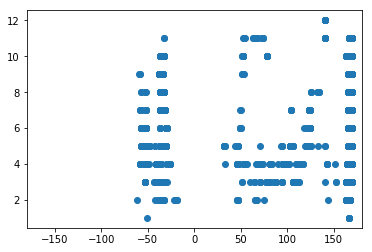

In [52]:
dfsel = dfmg.SHELF_BREAK_PROFILE & (dfmg.POT_DENSITY > 27.86)
plt.scatter(dfmg.loc[dfsel, "LONGITUDE"], dfmg.loc[dfsel, "JULD"].dt.month)
plt.xlim(-180, 180)
plt.show()

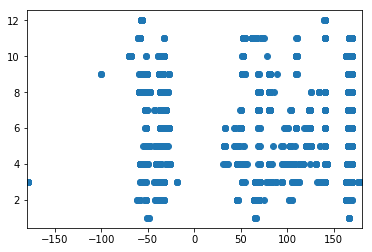

In [46]:
dfsel = dfmg.SHELF_BREAK_PROFILE & (dfmg.gamman > 28.27)
plt.scatter(dfmg.loc[dfsel, "LONGITUDE"], dfmg.loc[dfsel, "JULD"].dt.month)
plt.xlim(-180, 180)
plt.show()

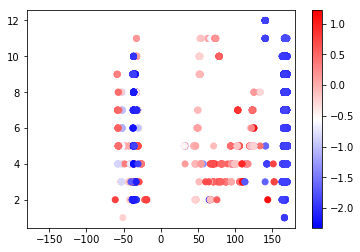

In [15]:
gn2 = 27.86
dfsel_gn2 = (dfmg.POT_DENSITY > gn2)
dfsel_slope = dfmg.SHELF_BREAK_PROFILE

plt.scatter(dfmg.loc[dfsel_slope & dfsel_gn2, "LONGITUDE"], dfmg.loc[dfsel_slope & dfsel_gn2, "JULD"].dt.month, 
           c=dfmg.loc[dfsel_slope & dfsel_gn2, "CTEMP"], cmap='bwr')
plt.xlim(-180, 180)
plt.colorbar()
plt.show()

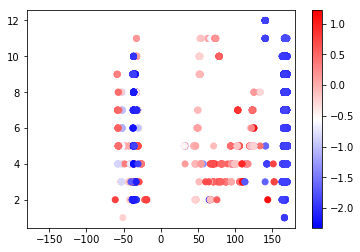

In [16]:
gn1 = 28.27
dfsel_gn1 = (dfmg.gamman > gn1)
dfsel_slope = dfmg.SHELF_BREAK_PROFILE

plt.scatter(dfmg.loc[dfsel_slope & dfsel_gn2, "LONGITUDE"], dfmg.loc[dfsel_slope & dfsel_gn2, "JULD"].dt.month, 
           c=dfmg.loc[dfsel_slope & dfsel_gn2, "CTEMP"], cmap='bwr')
plt.xlim(-180, 180)
plt.colorbar()
plt.show()

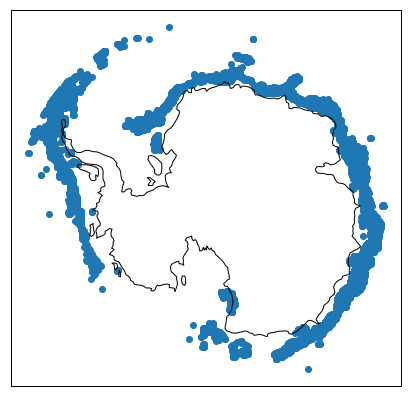

In [108]:
plt.close(1)
plt.figure(1, (7,7))
mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

lonlats = dfmg.loc[dfmg.SHELF_BREAK_PROFILE, ["LONGITUDE", "LATITUDE"]].drop_duplicates().values
mapax.scatter(lonlats[:, 0], lonlats[:, 1], transform=ccrs.PlateCarree())
mapax.coastlines()
plt.show()

In [3]:
dfmg.loc[dfmg.SHELF_BREAK_PROFILE, ["LONGITUDE", "LATITUDE"]].drop_duplicates().values

array([[ 47.2906, -64.3764],
       [ 47.5977, -64.471 ],
       [ 47.7729, -64.497 ],
       ...,
       [-59.3244, -61.6695],
       [-59.9921, -61.8558],
       [-62.638 , -62.2816]])

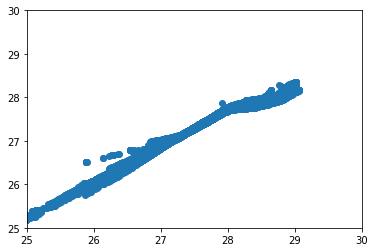

In [157]:
nonull = ~dfmg.gamman.isnull() & ~dfmg.POT_DENSITY.isnull() #& dfmg.SHELF_BREAK_PROFILE
plt.scatter(dfmg.loc[nonull, "gamman"], dfmg.loc[nonull, "POT_DENSITY"])
plt.xlim(25, 30)
plt.ylim(25, 30)
plt.show()

In [10]:
nonull = ~dfmg.gamman.isnull() & ~dfmg.POT_DENSITY.isnull() #& dfmg.SHELF_BREAK_PROFILE
density_linearfit = np.polyfit(dfmg.loc[nonull].gamman, dfmg.loc[nonull].POT_DENSITY, 1)
density_fitfn = np.poly1d(density_linearfit)

density_linearfit_inv = np.polyfit(dfmg.loc[nonull].POT_DENSITY, dfmg.loc[nonull].gamman, 1)
density_fitfn_inv = np.poly1d(density_linearfit_inv)

In [54]:
density_fitfn(28)

27.671176421450426

In [55]:
density_fitfn(28.1)

27.74134407948612

In [11]:
density_fitfn(28.27)

27.860629098146795

In [59]:
density_fitfn_inv(27.67)

27.98743073927166

In [93]:
import plot_sigma_surfaces as pss
importlib.reload(pss)

<module 'plot_sigma_surfaces' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_sigma_surfaces.py'>

<IPython.core.display.Javascript object>


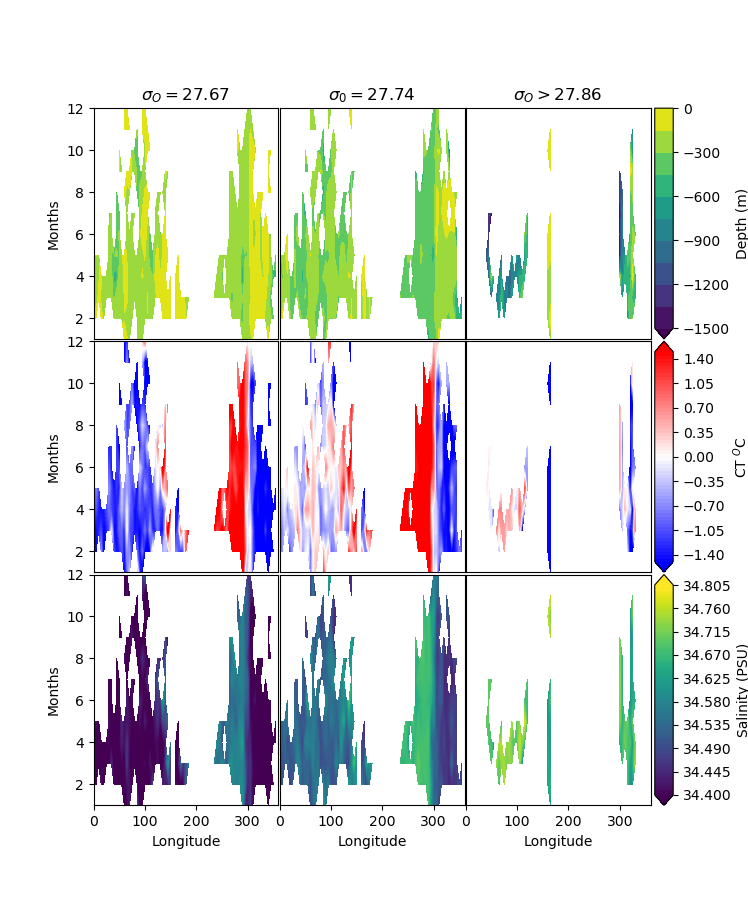

(72,) (72, 12)
(72,) (72, 12)
(72,) (72, 12)


In [94]:
pss.plot_slope_sigma0_surfaces_CF(dfmg, save=True, savename="./Images/slopeFront/sigma_surfaces_CF.jpg")

In [87]:
np.arange(-1.5, 1.5+0.01, 0.05)

array([-1.50000000e+00, -1.45000000e+00, -1.40000000e+00, -1.35000000e+00,
       -1.30000000e+00, -1.25000000e+00, -1.20000000e+00, -1.15000000e+00,
       -1.10000000e+00, -1.05000000e+00, -1.00000000e+00, -9.50000000e-01,
       -9.00000000e-01, -8.50000000e-01, -8.00000000e-01, -7.50000000e-01,
       -7.00000000e-01, -6.50000000e-01, -6.00000000e-01, -5.50000000e-01,
       -5.00000000e-01, -4.50000000e-01, -4.00000000e-01, -3.50000000e-01,
       -3.00000000e-01, -2.50000000e-01, -2.00000000e-01, -1.50000000e-01,
       -1.00000000e-01, -5.00000000e-02,  1.33226763e-15,  5.00000000e-02,
        1.00000000e-01,  1.50000000e-01,  2.00000000e-01,  2.50000000e-01,
        3.00000000e-01,  3.50000000e-01,  4.00000000e-01,  4.50000000e-01,
        5.00000000e-01,  5.50000000e-01,  6.00000000e-01,  6.50000000e-01,
        7.00000000e-01,  7.50000000e-01,  8.00000000e-01,  8.50000000e-01,
        9.00000000e-01,  9.50000000e-01,  1.00000000e+00,  1.05000000e+00,
        1.10000000e+00,  

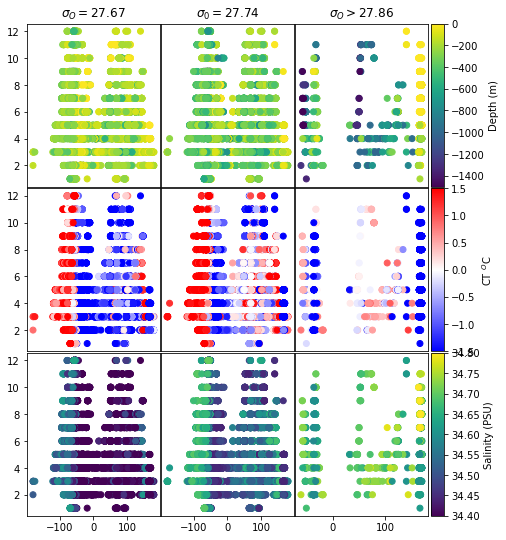

In [36]:
plot_slope_sigma0_surfaces_SCR(save=True, savename="./Images/slopeFront/sigma0_surfaces_Hovmoller_scatter.jpg")

In [81]:
np.arange(34.4, 34.8, 0.005)

array([34.4  , 34.405, 34.41 , 34.415, 34.42 , 34.425, 34.43 , 34.435,
       34.44 , 34.445, 34.45 , 34.455, 34.46 , 34.465, 34.47 , 34.475,
       34.48 , 34.485, 34.49 , 34.495, 34.5  , 34.505, 34.51 , 34.515,
       34.52 , 34.525, 34.53 , 34.535, 34.54 , 34.545, 34.55 , 34.555,
       34.56 , 34.565, 34.57 , 34.575, 34.58 , 34.585, 34.59 , 34.595,
       34.6  , 34.605, 34.61 , 34.615, 34.62 , 34.625, 34.63 , 34.635,
       34.64 , 34.645, 34.65 , 34.655, 34.66 , 34.665, 34.67 , 34.675,
       34.68 , 34.685, 34.69 , 34.695, 34.7  , 34.705, 34.71 , 34.715,
       34.72 , 34.725, 34.73 , 34.735, 34.74 , 34.745, 34.75 , 34.755,
       34.76 , 34.765, 34.77 , 34.775, 34.78 , 34.785, 34.79 , 34.795])